# Problem Statement

	
## Clean and prepare your data: 
- Clean dirty data
- Impute missing values where appropriate
- Feature engineer
- No external data.

## Build two models: 
1. Logistic Regression.
2. XGBoost

## Generate predictions:
- Predict on exercise_40_test.csv for each model.  
- Use class probability on positive class (labeled '1').  
- Output should be 10k rows, single column
	- NO HEADER LABEL OR INDEX COLUMN
- File titles:
	- glmresults.csv
	- nonglmresults.csv

## Compare the modeling approaches
- Write an executive summary to compare both models. 
- Include relative strengths and weaknesses of the algos (max points for doing at least one for each model).
- Include my statement (and supporting argument) for which will perform better on the test set.
- Include estimates for the test AUC's for each model.
	- Estimates should be in a table rounded to four decimal places.
- Describe how you would demonstrate to a business partner that one model is better than the other without using a score metric

## Submit your work (should inclue the following):
- All the code used for exploratory data analysis, cleaning, prepping, and modeling (text or pdf preferred) 
- The two results files (.csv format - each containing 10,000 decimal probabilities)
- The short report comparing the pros and cons of the two modeling techniques used (text or pdf preferred). 
	- Note: The results files should only include the column of probabilities.

## Important To keep in mind.

Your work will be evaluated in the following areas:
	• The appropriateness of the steps you took
	• The complexity of your models
	• The performance of each model on the test set (using AUC)
	• The organization and readability of your code
	• The write-up comparing the models

Please do not submit the original data back to us. 

---
# Data exploration and cleaning


## Assumptions
- There is no contamination between the training and test data. 
    - Even if some data points are exactly the same, they are assumed to be genuine and independent measurements.

In [25]:
# Core
import numpy as np
import pandas as pd
import warnings

# done to clean up warnings for pdf exporting
warnings.filterwarnings("ignore")

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Model tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Model Scoring
from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_curve


In [2]:
# Open up both files to see if they have the same columns (avoid data leakage)
traindf = pd.read_csv('../data/exercise_40_train.csv')
testdf = pd.read_csv('../data/exercise_40_test.csv')

In [3]:
traindf.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,...,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,...,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,...,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,...,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,...,3.003595,1.046096,yes,3.234033,2.074927,9.987006,11.702664,0,yes,92.925935


In [4]:
testdf.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,4.747627,20.509439,Wednesday,2.299105,-1.815777,-0.752166,0.0098%,-3.240309,0.587948,-0.260721,...,NaN,12.542333,no,3.107683,0.533904,12.438759,7.298306,0,NaN,93.567120
1,1.148654,19.301465,Fri,1.862200,-0.773707,-1.461276,0.0076%,0.443209,0.522113,-1.090886,...,-0.848567,7.213829,yes,4.276078,NaN,10.386987,12.527094,1,yes,98.607486
2,4.986860,18.769675,Saturday,1.040845,-1.548690,2.632948,-5e-04%,-1.167885,5.739275,0.222975,...,1.143388,10.483928,no,2.090868,-1.780474,11.328177,11.628247,0,yes,94.578246
3,3.709183,18.374375,Tuesday,-0.169882,-2.396549,-0.784673,-0.016%,-2.662226,1.548050,0.210141,...,0.693646,3.862867,no,2.643847,1.662240,10.064961,10.550014,1,NaN,100.346261
4,3.801616,20.205541,Monday,2.092652,-0.732784,-0.703101,0.0186%,0.056422,2.878167,-0.457618,...,-0.834763,3.632039,yes,4.074434,NaN,9.255766,12.716137,1,yes,102.578918


In [5]:
# check all column names are the same
train_cols = list(traindf.columns)
train_cols.remove('y')
test_cols = list(testdf.columns)

train_cols_set = set(train_cols)
test_cols_set = set(test_cols)

train_cols_set == test_cols_set

True

In [6]:
# column names are the same
# However, datatypes could be mismatched which may mean we need to investigate further
train_cols_type = [type(col) for col in train_cols]
test_cols_type = [type(col) for col in test_cols]

train_cols_type == test_cols_type

True

In [7]:
# All data types match, so there should be no target leakage.
# Let's see how many missing values per row there are.
(traindf
 .isna()
 .mean()
 .mul(100)
 .sort_values())


y       0.0000
x36     0.0000
x37     0.0000
x39     0.0000
x40     0.0000
        ...   
x52    40.4550
x55    44.2400
x30    80.8400
x57    81.1600
x44    85.6175
Length: 101, dtype: float64

In [8]:
# There are a lot of missing values in some feature.

# What about the balance of the data set
(traindf
    .y
    .mean())

0.145075

In [9]:
# The dataset if clearly unbalanced. 
# This can be addressed with undersampling our negative class later. 
# For now we will clean the dataset as well as we can.

# Look at the object columns to see what features we are dealing with.
s = (traindf.dtypes == 'object')
object_cols = list(s[s].index)

traindf[object_cols].head()

,x3,x7,x19,x24,x31,x33,x39,x60,x65,x77,x93,x99
0,Wed,0.0062%,$-908.650758424405,female,no,Colorado,5-10 miles,August,farmers,mercedes,no,yes
1,Friday,0.0064%,$-1864.9622875143,male,no,Tennessee,5-10 miles,April,allstate,mercedes,no,yes
2,Thursday,-8e-04%,$-543.187402955527,male,no,Texas,5-10 miles,September,geico,subaru,no,yes
3,Tuesday,-0.0057%,$-182.626380634258,male,no,Minnesota,5-10 miles,September,geico,nissan,no,yes
4,Sunday,0.0109%,$967.007090837503,male,yes,New York,5-10 miles,January,geico,toyota,yes,yes


x7 and x19 need to be reformatted into numbers. as a percent (div by 100) and float respectively

Let's look closely at each other variable to see if we need to apply any other type of cleaning.


In [10]:
for col in object_cols:
    if col not in ['x7','x19']:
        print(traindf[col].value_counts())

Wednesday    4930
Monday       4144
Friday       3975
Tuesday      3915
Sunday       3610
Saturday     3596
Tue          2948
Thursday     2791
Mon          2200
Wed          2043
Sat          1787
Thur         1643
Fri          1620
Sun           798
Name: x3, dtype: int64
female    18158
male      17986
Name: x24, dtype: int64
no     34022
yes     5978
Name: x31, dtype: int64
California        3393
Texas             2252
Florida           1802
New York          1714
Illinois          1240
Pennsylvania      1233
Ohio              1114
Michigan           982
Georgia            918
North Carolina     910
New Jersey         870
Virginia           791
Washington         750
Tennessee          690
Indiana            674
Arizona            665
Massachusetts      638
Wisconsin          635
Missouri           634
Minnesota          611
Maryland           581
Alabama            554
Colorado           530
Louisiana          501
South Carolina     491
Kentucky           478
Oregon             45

In [11]:
# double check that this feature only has one value
traindf.x39.value_counts()

5-10 miles    40000
Name: x39, dtype: int64

In [12]:
# make sure these two features arent the same
(traindf.x31==traindf.x93).mean()

0.8898

Write some methods for our object columns that require changes.

- x3: Day of the week
    - Create a map for day of week abbreviations

- x7: Percentage. 
    - remove percentage character (if it exists) 
    - Convert to float
    - divide by 100

- x19: Money
    - remove the dollar sign character
    - convert to float
    
- x24: male/female
    - nothing (will be one-hot encoded)

- x31: yes/no
    - nothing (will be one-hot encoded)

- x33: State
    - nothing (will be one-hot encoded)

- x39: miles
    - drop

- x60: month
    - nothing (will be one-hot encoded)

- x65: ins provider
    - nothing (will be one-hot encoded)

- x77: car manufacturer
    - nothing (will be one-hot encoded)

- x93: yes/no
    - nothing (will be one-hot encoded)

- x99: yes/no
    - nothing (will be one-hot encoded)

In [13]:
def map_dow(value):
    dow_map = {
        "Mon": "Monday",
        "Tue": "Tuesday",
        "Wed": "Wednesday",
        "Sat": "Saturday",
        "Thur": "Thursday",
        "Fri": "Friday",
        "Sun": "Sunday"}
    if value in dow_map.keys():
        return dow_map[value]
    else:
        return value

# for the two numerical columns no imputing is done at this stage

def convert_percentage(value):
    try:
        if value[-1]=='%':
            return float(value[:-1])/100
        else:
            return value
    except:
        return value

def convert_dollar(value):
    try:
        if value[0] =='$':
            return float(value[1:])
        else:
            return value
    except:
        return value
    
def fix_object_cols(dataframe):
    df = dataframe.copy()
    df.loc[:,'x3'] = df['x3'].apply(map_dow)
    df.loc[:,'x7'] = df['x7'].apply(convert_percentage)
    df.loc[:,'x19'] = df['x19'].apply(convert_dollar)
    df.drop(columns=['x39'])
    return df

In [14]:
traindf_t1 = fix_object_cols(traindf)

In [15]:
traindf_t1[object_cols]

,x3,x7,x19,x24,x31,x33,x39,x60,x65,x77,x93,x99
0,Wednesday,0.000062,-908.650758,female,no,Colorado,5-10 miles,August,farmers,mercedes,no,yes
1,Friday,0.000064,-1864.962288,male,no,Tennessee,5-10 miles,April,allstate,mercedes,no,yes
2,Thursday,-0.000008,-543.187403,male,no,Texas,5-10 miles,September,geico,subaru,no,yes
3,Tuesday,-0.000057,-182.626381,male,no,Minnesota,5-10 miles,September,geico,nissan,no,yes
4,Sunday,0.000109,967.007091,male,yes,New York,5-10 miles,January,geico,toyota,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,Sunday,-0.000085,3750.519920,female,no,NaN,5-10 miles,July,farmers,NaN,no,yes
39996,Thursday,0.000077,448.867118,male,yes,Illinois,5-10 miles,July,progressive,ford,no,yes
39997,Monday,-0.000216,834.957751,male,yes,NaN,5-10 miles,August,geico,ford,no,yes
39998,Tuesday,0.000001,-48.103100,male,no,Ohio,5-10 miles,December,farmers,NaN,no,yes


# Reblance the data set and drop sparse features

In [20]:
traindf_t1.query('y==1').y.sum()

5803

In [21]:
pos_sample = traindf_t1.query('y==1').sample(5500)
neg_sample = traindf_t1.query('y==0').sample(5500)

# now X is these two combined
newdf = pd.concat([pos_sample, neg_sample], axis=0)
X = newdf.drop(columns=['y'])
y = newdf['y']

# Drop columns not reaching a certain threshold
missing_series = (X 
               .isna() 
               .mean() 
               .mul(100))
mask = missing_series.gt(50)
cols = list(missing_series.loc[mask].index)
X.drop(columns=cols, inplace=True)

# the data set is split here but not used since our gridsearches automatically split the dataset as it performs k-fold validation
Xtrain, Xval, ytrain, yval = train_test_split(X, y)

# Create some preprocessing Pipelines to be used by both models

In [39]:
s = (traindf.dtypes == 'object')
object_cols = list(s[s].index)
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

num_transform = SimpleImputer(strategy='constant')
cat_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# use a column transformer to recombine these different transformations easily
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transform, numerical_cols),
        ('cat', cat_transform, object_cols)
    ]
)

---
# Logistic Regression

In [31]:
# now set up another model and make a new pipeline between the two
logreg = LogisticRegression(max_iter=1000)

logregpipe = Pipeline(steps=[
                        ('preproc', preprocessor), 
                        ('model',logreg)
                       ])

gridsearch = GridSearchCV(logregpipe, {'model__C':[0.01,0.03,0.1,0.3,1,3,10]}, scoring='roc_auc')
gridsearch.fit(X, y)


GridSearchCV(estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(strategy='constant'),
                                                                         ['x1',
                                                                          'x2',
                                                                          'x4',
                                                                          'x5',
                                                                          'x6',
                                                                          'x7',
                                                                          'x8',
                                                                          'x9',
                                                                          'x10',
                                       

In [32]:
bestlog = gridsearch.best_estimator_
valscore = bestlog.score(Xval, yval)
preds = bestlog.predict(Xval)

prec = precision_score(yval, preds)
rec = recall_score(yval, preds)
fpr, tpr, thresholds = roc_curve(yval, preds, pos_label=2)
auc_score = auc(fpr, tpr)

print(f"Val Accurace: {valscore}")
print(f"Precision:    {prec}")
print(f"Recall:       {rec}")
print(f"AUC:          {auc_score}")

Val Accurace: 0.6007272727272728
Precision:    0.6085989621942179
Recall:       0.5902228612508986
AUC:          nan


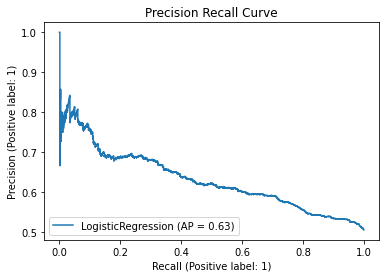

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

# train the best estimator on the training data for demonstration
bestlog.fit(Xtrain,ytrain)

display = PrecisionRecallDisplay.from_estimator(
    bestlog, Xval, yval, name="LogisticRegression"
)

_ = display.ax_.set_title("Precision Recall Curve")

# Logistic Regression Prototype Summary

It appears the logistic regression classifier does not perform well at all, despite the accuracy being 85%.
The model naively predicts that every output should be 0.
On top of the poor performance for the default class paramaters, tuning the inverse regularization constant doesn't help the performance at all.
This is likely a consequence of the dataset being imbalanced, with about 15% positive classes and 85% negative classes.

The Logisitic regression would probably work better if the dataset was balance, or if there were a lot more data. 


---
## XGBoost Tuning


In [40]:

# Separate object and numerical columns for imputation.

parameters = {
    'model__max_depth': [1, 2, 4],
    'model__n_estimators': [60, 120, 180, 240],
    'model__learning_rate': [0.1, 0.01, 0.05]
}


#params={'max_depth': range(3, 19),
        #'gamma': range(1,10),
        #'reg_alpha' : range(40,180,20),
        #'reg_lambda' : [0,1],
        #'min_child_weight' : range(0, 10),
        #'n_estimators': 180,
        #'seed': 0
    #}

xgbclass = XGBClassifier(use_label_encoder=False,eval_metric='rmse')

xgbpipe = Pipeline(steps=[
                        ('preproc', preprocessor), 
                        ('model', xgbclass)
                    ])


rcv = RandomizedSearchCV(xgbpipe, parameters, scoring='roc_auc')
rcv.fit(X, y)



RandomizedSearchCV(estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='constant'),
                                                                               ['x1',
                                                                                'x2',
                                                                                'x4',
                                                                                'x5',
                                                                                'x6',
                                                                                'x7',
                                                                                'x8',
                                                                                'x9',
                                                      

In [41]:
bestxgb = gridsearch.best_estimator_
valscore = bestxgb.score(Xval, yval)
preds = bestxgb.predict(Xval)

prec = precision_score(yval, preds)
rec = recall_score(yval, preds)
fpr, tpr, thresholds = roc_curve(yval, preds, pos_label=2)
auc_score = auc(fpr, tpr)

print(f"Val Accurace: {valscore}")
print(f"Precision:    {prec}")
print(f"Recall:       {rec}")
print(f"AUC:          {auc_score}")

Val Accurace: 0.5934545454545455
Precision:    0.5838368580060423
Recall:       0.576865671641791
AUC:          nan


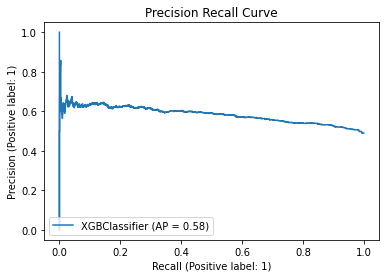

In [42]:

bestxgb.fit(Xtrain,ytrain)

display = PrecisionRecallDisplay.from_estimator(
    bestxgb, Xval, yval, name="XGBClassifier"
)

_ = display.ax_.set_title("Precision Recall Curve")

# Export test data with the two models



In [43]:
# Prepare the test data like we did training
test_df1 = fix_object_cols(testdf)
missing_series = (test_df1
               .isna() 
               .mean() 
               .mul(100))
mask = missing_series.gt(50)
cols = list(missing_series.loc[mask].index)
test_df1.drop(columns=cols, inplace=True)

In [46]:
# train on the full data set then predict
bestlog.fit(X,y)
logtestpred = bestlog.predict(test_df1)

bestxgb.fit(X,y)
xgbtestpred = bestxgb.predict(test_df1)

In [51]:
pd.Series(logtestpred).to_csv('../data/glmresults.csv', header=False, index=False)
pd.Series(xgbtestpred).to_csv('../data/nonglmresults.csv', header=False, index=False)